In [9]:
import os

os.chdir("/home/bartosz.cywinski@aiclearing.com/code/ensemble-ai2024/modelstealing")

In [33]:
import sys

sys.path.append("../end2end-stealing")

In [34]:
import torch
from taskdataset import TaskDataset


dataset = torch.load("data/ModelStealingPub.pt")

In [35]:
len(dataset)

13000

In [59]:
import vision_transformer as vits
import torchvision.models as models
import torchvision
import numpy as np

In [38]:
victim_model = models.__dict__["resnet50"]()
checkpoint = torch.load(
    "/home/bartosz.cywinski@aiclearing.com/code/ensemble-ai2024/end2end-stealing/pretrained_weights/checkpoint_0099.pth.tar",
    map_location="cpu",
)
state_dict = checkpoint["state_dict"]
for k in list(state_dict.keys()):
    # retain only encoder up to before the embedding layer
    if k.startswith("module.encoder") and not k.startswith("module.encoder.fc"):
        # remove prefix
        state_dict[k[len("module.encoder.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
# print("state dict", state_dict.keys())
victim_model.load_state_dict(state_dict, strict=False)
victim_model.fc = torch.nn.Identity()
victim_model.cuda()
victim_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
dataset[0]

(73838,
 <PIL.Image.Image image mode=RGB size=32x32 at 0x798690221AE0>,
 '40019202')

In [112]:
features = []
to_tensor = torchvision.transforms.ToTensor()

for iid, img, label in dataset:
    with torch.no_grad():
        img = img.convert("RGB")
        img = to_tensor(img).unsqueeze(0)

        victim_model(img.to("cuda"))
        features.append(victim_model(img.to("cuda")).cpu().numpy())

In [113]:
features = torch.from_numpy(np.array(features))

In [114]:
features.shape

torch.Size([13000, 1, 2048])

In [115]:
features = features.view(features.shape[0], -1)

In [120]:
features.shape

torch.Size([13000, 2048])

In [121]:
import umap

In [122]:
reducer = umap.UMAP()

In [123]:
embs = reducer.fit_transform(features)

In [124]:
labels = [label for iid, img, label in dataset]

In [125]:
label_map = {l: i for i, l in enumerate(set(labels))}

In [126]:
labels_int = [label_map[l] for l in labels]

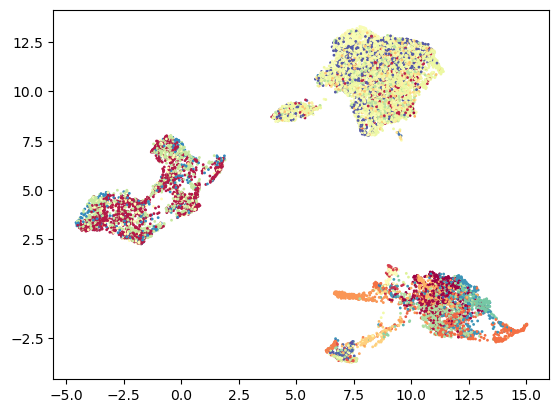

In [127]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    embs[:, 0], embs[:, 1], label=labels_int, c=labels_int, cmap="Spectral", s=1
)
plt.show()

In [128]:
from collections import Counter

In [129]:
class_cnt = Counter(labels_int)

In [130]:
class_cnt

Counter({28: 1775,
         2: 1584,
         26: 1346,
         32: 1134,
         48: 833,
         33: 502,
         34: 443,
         0: 423,
         22: 420,
         43: 378,
         44: 360,
         38: 340,
         9: 329,
         13: 325,
         10: 316,
         24: 286,
         17: 278,
         1: 273,
         15: 270,
         3: 265,
         19: 178,
         18: 155,
         25: 110,
         31: 78,
         47: 72,
         27: 66,
         11: 52,
         5: 41,
         35: 37,
         49: 32,
         16: 32,
         14: 27,
         7: 26,
         21: 19,
         37: 18,
         4: 17,
         45: 16,
         20: 16,
         30: 16,
         23: 15,
         12: 14,
         42: 13,
         36: 13,
         29: 12,
         40: 10,
         8: 10,
         46: 9,
         6: 9,
         39: 4,
         41: 3})

<BarContainer object of 50 artists>

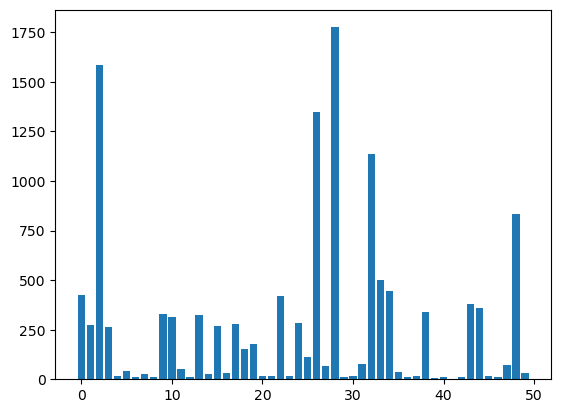

In [131]:
plt.bar(class_cnt.keys(), class_cnt.values())

In [94]:
distances = torch.cdist(features, features)

In [95]:
distances.shape

torch.Size([13000, 13000])

In [101]:
order = list(distances.mean(dim=1).sort()[1])[::-1]

In [103]:
order = [x.item() for x in order]

In [105]:
all_images = [img for iid, img, label in dataset]
chosen_images = np.array(all_images)[order][:100]

/tmp/ipykernel_71570/3161812555.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  chosen_images = np.array(all_images)[order][:100]
/tmp/ipykernel_71570/3161812555.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chosen_images = np.array(all_images)[order][:100]


In [106]:
len(chosen_images)

100

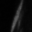

In [107]:
chosen_images[0]

In [108]:
chosen_features = features[order][:100]

In [109]:
sorted_embs = embs[order]

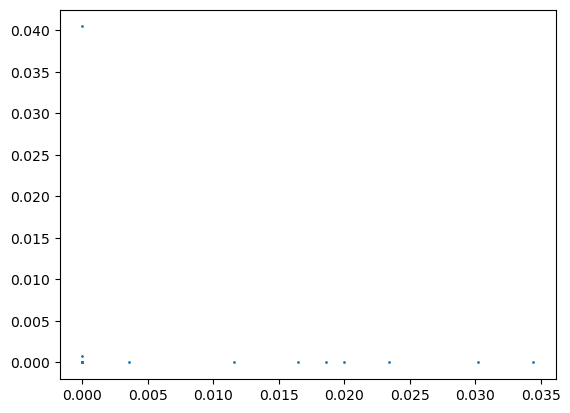

In [111]:
plt.figure()
plt.scatter(
    chosen_features[:100, 0],
    chosen_features[:100, 1],
    # label=labels_int,
    # c=labels_int,
    cmap="Spectral",
    s=1,
)
plt.show()